In [4]:
!pip install ace
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


## treatment decay mode

         X1        X2  T  time         Y
0  0.496714  1.030595  0     4  2.414756
1 -0.138264 -1.155355  0     1  3.381198
2  0.647689  0.575437  0     8  2.093445
3  1.523030 -0.619238  0     0  2.660579
4 -0.234153 -0.327403  0     0  2.791404


/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_90326/3127246826.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='time', y='Y', hue='T', data=df_large, ci=None)


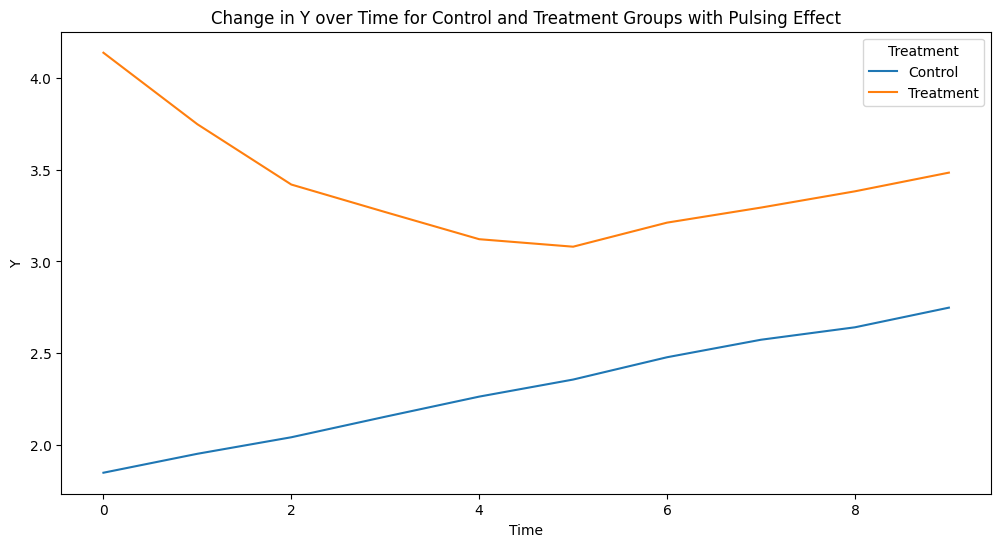

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed for reproducibility
np.random.seed(42)

# Generate a larger dataset with 10,000 samples
n = 100_000  # number of samples
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)

# Generate treatment variable with some dependence on covariates
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))

# Generate time variable
time = np.random.randint(0, 10, n)  # Random time points between 0 and 9

# Define the initial strong treatment effect and its decay
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5

# Generate outcome variable with a pulsing treatment effect that stabilizes over time
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)

Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

# Create a DataFrame
df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'time': time,
    'Y': Y
})

# Display the first few rows of the dataset
print(df_large.head())

# Plot the dataset with the pulsing treatment effect
plt.figure(figsize=(12, 6))

# Plot the change in Y over time for control and treatment groups
sns.lineplot(x='time', y='Y', hue='T', data=df_large, ci=None)
plt.title('Change in Y over Time for Control and Treatment Groups with Pulsing Effect')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend(title='Treatment', labels=['Control', 'Treatment'])
plt.show()


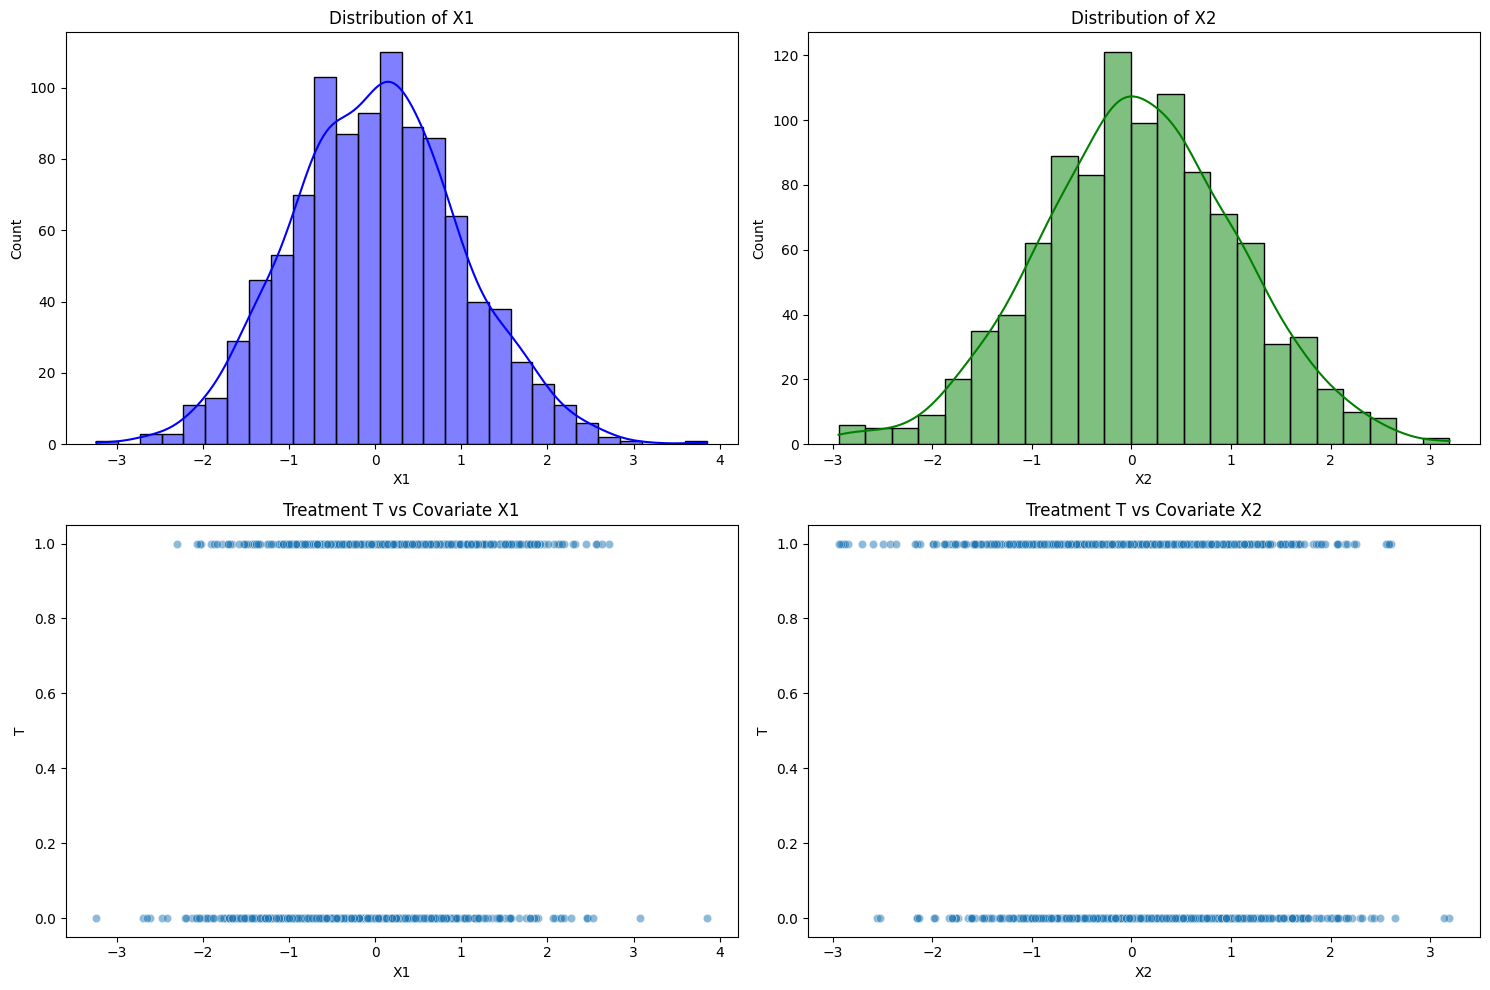

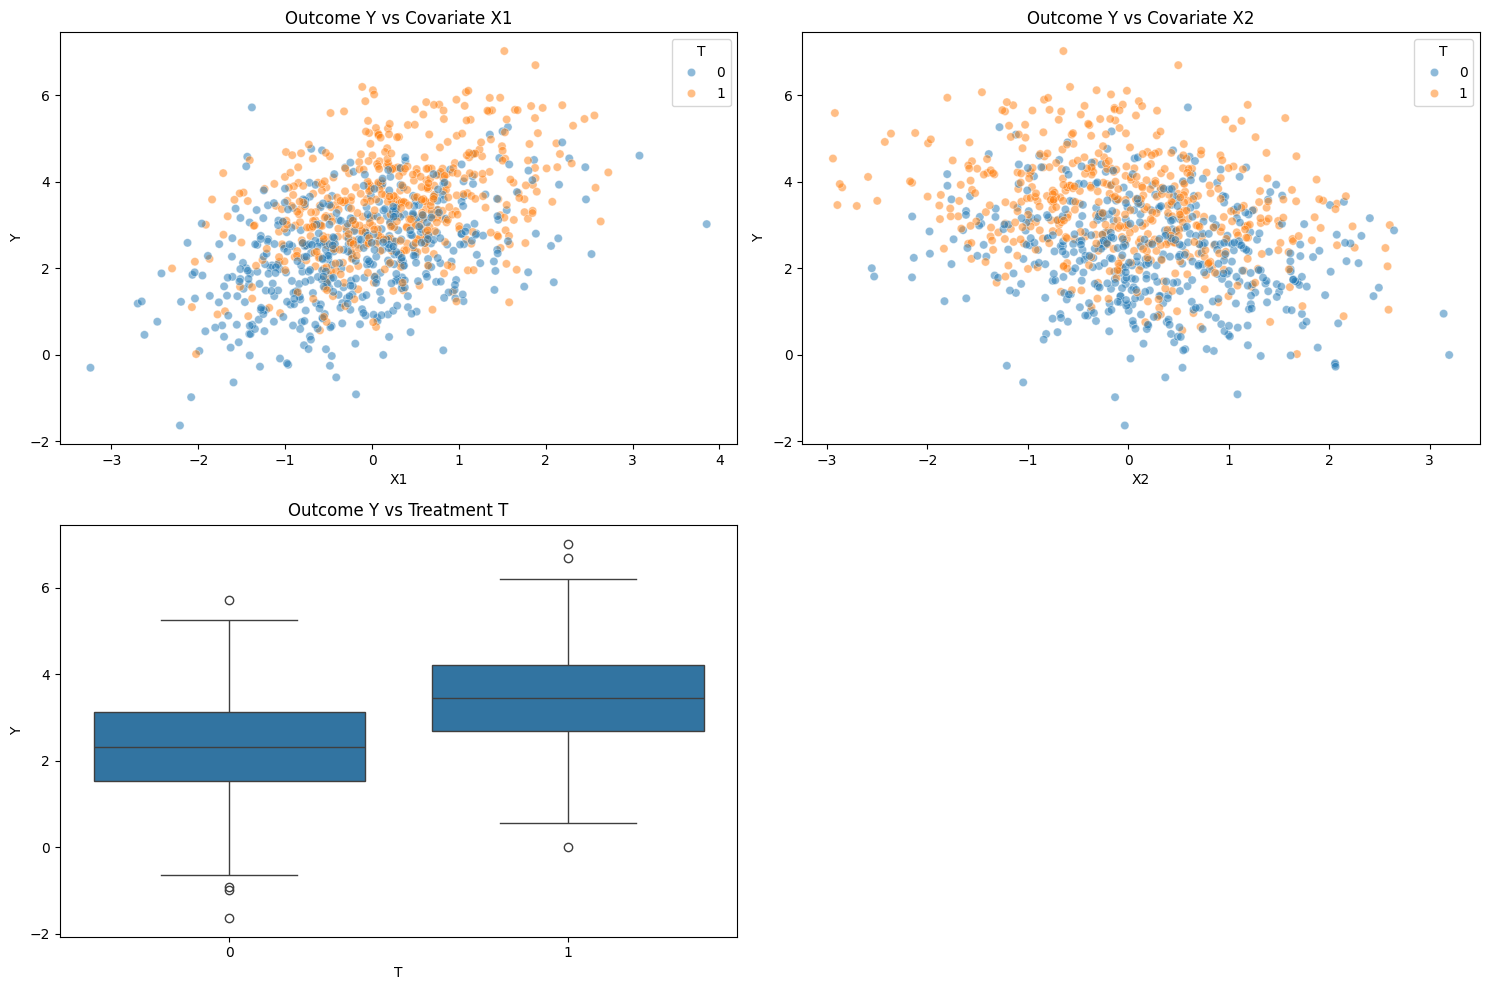

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot the distribution of the covariates
plt.subplot(2, 2, 1)
sns.histplot(df['X1'], kde=True, color='blue')
plt.title('Distribution of X1')
plt.xlabel('X1')

plt.subplot(2, 2, 2)
sns.histplot(df['X2'], kde=True, color='green')
plt.title('Distribution of X2')
plt.xlabel('X2')

# Plot the relationship between the treatment variable and the covariates
plt.subplot(2, 2, 3)
sns.scatterplot(x='X1', y='T', data=df, alpha=0.5)
plt.title('Treatment T vs Covariate X1')
plt.xlabel('X1')
plt.ylabel('T')

plt.subplot(2, 2, 4)
sns.scatterplot(x='X2', y='T', data=df, alpha=0.5)
plt.title('Treatment T vs Covariate X2')
plt.xlabel('X2')
plt.ylabel('T')

plt.tight_layout()
plt.show()

# Set up another figure
plt.figure(figsize=(15, 10))

# Plot the relationship between the outcome variable and the covariates
plt.subplot(2, 2, 1)
sns.scatterplot(x='X1', y='Y', data=df, alpha=0.5, hue='T')
plt.title('Outcome Y vs Covariate X1')
plt.xlabel('X1')
plt.ylabel('Y')

plt.subplot(2, 2, 2)
sns.scatterplot(x='X2', y='Y', data=df, alpha=0.5, hue='T')
plt.title('Outcome Y vs Covariate X2')
plt.xlabel('X2')
plt.ylabel('Y')

# Plot the effect of the treatment variable on the outcome variable
plt.subplot(2, 2, 3)
sns.boxplot(x='T', y='Y', data=df)
plt.title('Outcome Y vs Treatment T')
plt.xlabel('T')
plt.ylabel('Y')

plt.tight_layout()
plt.show()


## NN fit it directly

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate the dataset as previously described
n = 100_000
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'time': time,
    'Y': Y
})

# Prepare the data for training
X = df_large[['X1', 'X2', 'T', 'time']].values
y = df_large['Y'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_split=0.2, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
y_pred = model.predict([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]])

# Separate treatment and control predictions
control_indices = X_test[:, 3] == 0
treatment_indices = X_test[:, 3] == 1

y_test_control = y_test[control_indices]
y_pred_control = y_pred[control_indices]

y_test_treatment = y_test[treatment_indices]
y_pred_treatment = y_pred[treatment_indices]

# Plot true vs predicted values for control and treatment groups
plt.figure(figsize=(8, 6))
plt.scatter(y_test_control, y_pred_control, alpha=0.5, label='Control', color='blue')
plt.scatter(y_test_treatment, y_pred_treatment, alpha=0.5, label='Treatment', color='orange')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal')
plt.legend()
plt.show()

Epoch 1/10
 18/640 [..............................] - ETA: 1s - loss: 4.8291  

2024-06-01 16:25:33.106567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


628/640 [============================>.] - ETA: 0s - loss: 1.1708

2024-06-01 16:25:35.002641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


640/640 [==============================] - 2s 3ms/step - loss: 1.1682 - val_loss: 1.0272
Epoch 2/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0249 - val_loss: 1.0366
Epoch 3/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0217 - val_loss: 1.0315
Epoch 4/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0211 - val_loss: 1.0213
Epoch 5/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0192 - val_loss: 1.0258
Epoch 6/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0184 - val_loss: 1.0199
Epoch 7/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0201 - val_loss: 1.0285
Epoch 8/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0185 - val_loss: 1.0320
Epoch 9/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0171 - val_loss: 1.0220
Epoch 10/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0162 - val_loss: 1.0224


2024-06-01 16:25:54.088381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 1.0190378427505493


ValueError: in user code:

    File "/opt/homebrew/anaconda3/envs/python-notebook/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/anaconda3/envs/python-notebook/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/anaconda3/envs/python-notebook/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/anaconda3/envs/python-notebook/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/anaconda3/envs/python-notebook/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/anaconda3/envs/python-notebook/lib/python3.8/site-packages/keras/engine/input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "sequential_4" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32,) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32,) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(32, 2) dtype=float32>]


Epoch 1/10


2024-06-01 16:50:37.836783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


629/640 [============================>.] - ETA: 0s - loss: 1.6950

2024-06-01 16:50:40.725290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


640/640 [==============================] - 3s 5ms/step - loss: 1.6887 - val_loss: 1.3077
Epoch 2/10
640/640 [==============================] - 2s 4ms/step - loss: 1.2153 - val_loss: 1.1762
Epoch 3/10
640/640 [==============================] - 2s 3ms/step - loss: 1.1233 - val_loss: 1.1139
Epoch 4/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0866 - val_loss: 1.0913
Epoch 5/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0791 - val_loss: 1.0817
Epoch 6/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0770 - val_loss: 1.0776
Epoch 7/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0763 - val_loss: 1.0860
Epoch 8/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0762 - val_loss: 1.0801
Epoch 9/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0745 - val_loss: 1.0788
Epoch 10/10
640/640 [==============================] - 2s 3ms/step - loss: 1.0744 - val_loss: 1.0830


2024-06-01 16:51:00.591760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 1.085679531097412
 70/625 [==>...........................] - ETA: 0s

2024-06-01 16:51:02.069164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 1s 1ms/step


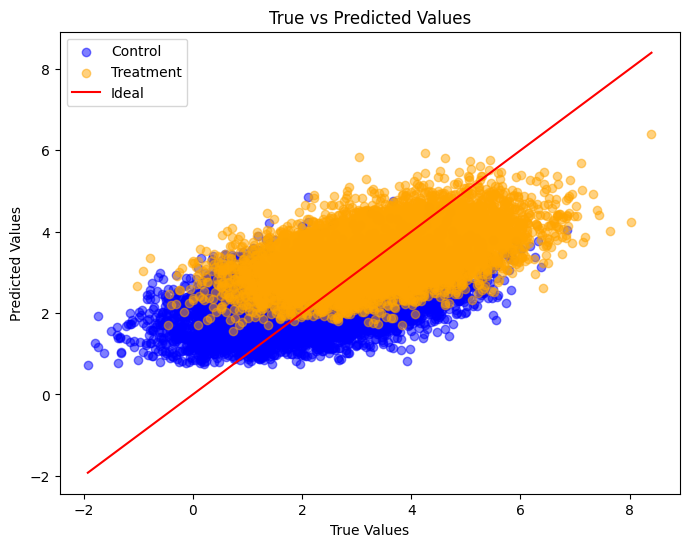

Test loss: 1.085679531097412
625/625 [==============================] - 1s 1ms/step


In [66]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate the dataset as previously described
n = 100_000
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'time': time,
    'Y': Y
})

# Prepare the data for training
X = df_large[['X1', 'X2', 'time']].values
T_input = df_large['T'].values.reshape(-1, 1)
y = df_large['Y'].values

# Split the data into training and testing sets
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T_input, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the neural network model with custom layers
input_features = Input(shape=(X_train.shape[1],))
treatment_input = Input(shape=(1,))

x = Dense(64, activation='relu')(input_features)
x = Dense(32, activation='relu')(x)
x = Dense(1)(x)
y_hat = Lambda(lambda x: tf.exp(x))(x)

# Concatenate the treatment input
concatenated = Concatenate()([y_hat, treatment_input])

# Define the output layer
output = Dense(1)(concatenated)

# Create the model
model = Model(inputs=[input_features, treatment_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit([X_train, T_train], y_train, epochs=10, batch_size=100, validation_split=0.2, verbose=1)

# Evaluate the model
loss = model.evaluate([X_test, T_test], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
y_pred = model.predict([X_test, T_test])

# Separate treatment and control predictions
control_indices = T_test[:, 0] == 0
treatment_indices = T_test[:, 0] == 1

y_test_control = y_test[control_indices]
y_pred_control = y_pred[control_indices]

y_test_treatment = y_test[treatment_indices]
y_pred_treatment = y_pred[treatment_indices]

# Plot true vs predicted values for control and treatment groups
plt.figure(figsize=(8, 6))
plt.scatter(y_test_control, y_pred_control, alpha=0.5, label='Control', color='blue')
plt.scatter(y_test_treatment, y_pred_treatment, alpha=0.5, label='Treatment', color='orange')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal')
plt.legend()
plt.show()


# Evaluate the model
loss = model.evaluate([X_test, T_test], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
y_pred = model.predict([X_test, T_test])
pred_mean = y_pred[:, 0]

# Calculate the uplift score
uplift_score = pred_mean - y_test

# Calculate the uplift score
uplift_score = pred_mean - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score)[::-1]
y_test_sorted = y_test[sorted_indices]
T_test_sorted = T_test[sorted_indices]

# Calculate cumulative uplift
cumulative_uplift = np.cumsum((T_test_sorted - (1 - T_test_sorted)) * y_test_sorted)
cumulative_uplift /= np.arange(1, len(cumulative_uplift) + 1)

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_uplift, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend()
plt.show()

# Calculate AUUC
auuc = np.trapz(cumulative_uplift)
print(f'AUUC: {auuc}')



Epoch 1/10


2024-06-01 16:44:07.586845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/64 [===========================>..] - ETA: 0s - loss: 7.3931

2024-06-01 16:44:09.327214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 3s 17ms/step - loss: 7.2050 - val_loss: 4.3969
Epoch 2/10
64/64 [==============================] - 1s 12ms/step - loss: 3.7443 - val_loss: 3.1551
Epoch 3/10
64/64 [==============================] - 1s 12ms/step - loss: 3.0199 - val_loss: 2.7734
Epoch 4/10
64/64 [==============================] - 1s 13ms/step - loss: 2.7033 - val_loss: 2.5237
Epoch 5/10
64/64 [==============================] - 1s 13ms/step - loss: 2.4383 - val_loss: 2.2576
Epoch 6/10
64/64 [==============================] - 1s 12ms/step - loss: 2.1230 - val_loss: 1.9475
Epoch 7/10
64/64 [==============================] - 1s 12ms/step - loss: 1.8599 - val_loss: 1.7794
Epoch 8/10
64/64 [==============================] - 1s 12ms/step - loss: 1.7614 - val_loss: 1.7335
Epoch 9/10
64/64 [==============================] - 1s 13ms/step - loss: 1.7366 - val_loss: 1.7256
Epoch 10/10
64/64 [==============================] - 1s 13ms/step - loss: 1.7292 - val_loss: 1.7201


2024-06-01 16:44:16.889179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 1.7068685293197632
 1/63 [..............................] - ETA: 15s

2024-06-01 16:44:17.926859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 10ms/step


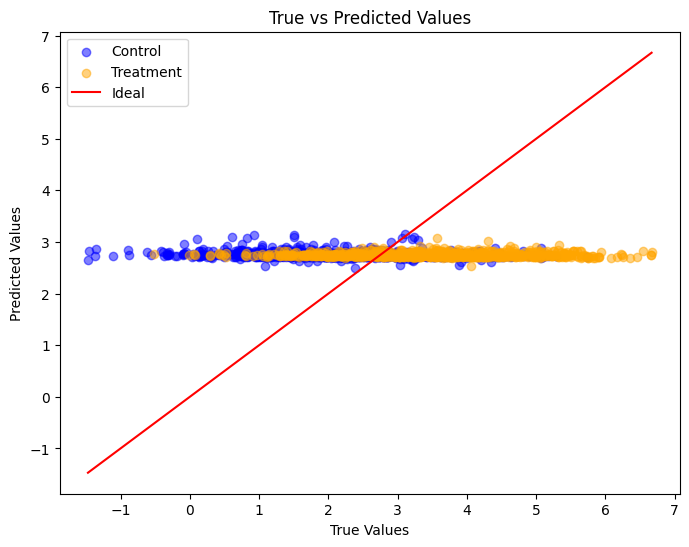

Test loss: 1.7068685293197632
63/63 [==============================] - 0s 5ms/step


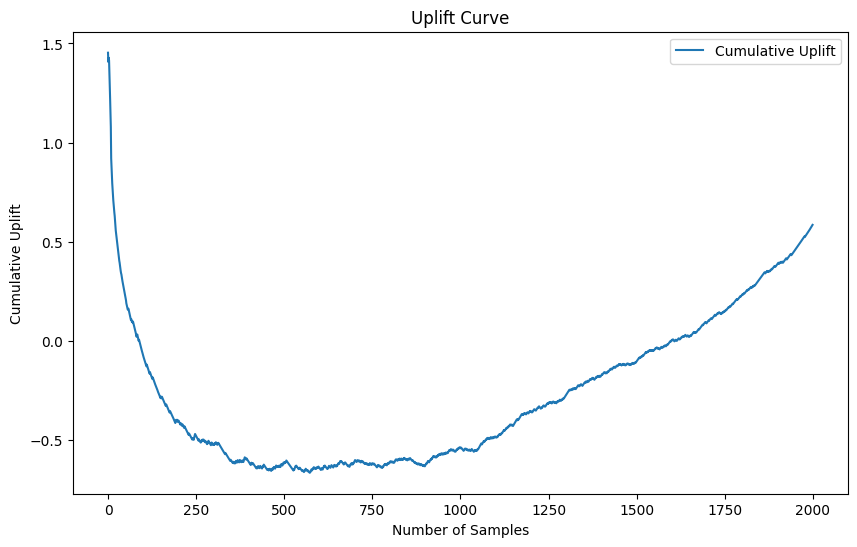

AUUC: -541.3163971349414


In [59]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention, Lambda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate the dataset as previously described
n = 10000
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'time': time,
    'Y': Y
})

# Prepare the data for training
X = df_large[['time', 'X1', 'X2', 'T']].values
y = df_large['Y'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train[:, 1:3] = scaler.fit_transform(X_train[:, 1:3])
X_test[:, 1:3] = scaler.transform(X_test[:, 1:3])

# Define Transformer block
def transformer_block(inputs, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

# Define the neural network model
input0 = Input(shape=(1,), name='time')
input1 = Input(shape=(1,), name='treatment')
input2 = Input(shape=(2,), name='features')

# Concatenate inputs for the transformer block
concat_inputs = Concatenate()([input0, input1, input2])
concat_inputs = tf.expand_dims(concat_inputs, axis=1)

# Apply transformer block
transformer_output = transformer_block(concat_inputs, num_heads=2, ff_dim=32)
transformer_output = tf.squeeze(transformer_output, axis=1)

# Output layers for mean and log variance
mean = Dense(1)(transformer_output)
log_variance = Dense(1)(transformer_output)

# Concatenate mean and variance to create a distribution
output = Concatenate()([mean, log_variance])

# Create the model
model = Model(inputs=[input0, input1, input2], outputs=output)

# Define the negative log-likelihood loss function
def nll(y_true, y_pred):
    mean = y_pred[:, 0]
    log_variance = y_pred[:, 1]
    variance = tf.exp(log_variance)
    return 0.5 * tf.reduce_mean(tf.math.log(2 * np.pi * variance) + tf.square(y_true - mean) / variance)

# Compile the model
model.compile(optimizer='adam', loss=nll)

# Train the model
history = model.fit(
    [X_train[:, 0], X_train[:, 3], X_train[:, 1:3]], 
    y_train, 
    epochs=10, 
    batch_size=100, 
    validation_split=0.2, 
    verbose=1
)

# Evaluate the model
loss = model.evaluate([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
y_pred = model.predict([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]])
pred_mean = y_pred[:, 0]

# Separate treatment and control predictions
control_indices = X_test[:, 3] == 0
treatment_indices = X_test[:, 3] == 1

y_test_control = y_test[control_indices]
pred_mean_control = pred_mean[control_indices]

y_test_treatment = y_test[treatment_indices]
pred_mean_treatment = pred_mean[treatment_indices]

# Plot true vs predicted values for control and treatment groups
plt.figure(figsize=(8, 6))
plt.scatter(y_test_control, pred_mean_control, alpha=0.5, label='Control', color='blue')
plt.scatter(y_test_treatment, pred_mean_treatment, alpha=0.5, label='Treatment', color='orange')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal')
plt.legend()
plt.show()


# Evaluate the model
loss = model.evaluate([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
y_pred = model.predict([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]])
pred_mean = y_pred[:, 0]

# Calculate the uplift score
uplift_score = pred_mean - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score)[::-1]
y_test_sorted = y_test[sorted_indices]
T_test_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift = np.cumsum((T_test_sorted - (1 - T_test_sorted)) * y_test_sorted)
cumulative_uplift /= np.arange(1, len(cumulative_uplift) + 1)

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_uplift, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend()
plt.show()

# Calculate AUUC
auuc = np.trapz(cumulative_uplift)
print(f'AUUC: {auuc}')


Epoch 1/10


2024-06-01 16:40:02.066044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


638/640 [============================>.] - ETA: 0s - loss: 2.1536

2024-06-01 16:40:09.587922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


640/640 [==============================] - 9s 12ms/step - loss: 2.1505 - val_loss: 1.2499
Epoch 2/10
640/640 [==============================] - 7s 11ms/step - loss: 1.1897 - val_loss: 1.1023
Epoch 3/10
640/640 [==============================] - 7s 11ms/step - loss: 1.0890 - val_loss: 1.0535
Epoch 4/10
640/640 [==============================] - 7s 11ms/step - loss: 1.0592 - val_loss: 1.0430
Epoch 5/10
640/640 [==============================] - 7s 11ms/step - loss: 1.0551 - val_loss: 1.0332
Epoch 6/10
640/640 [==============================] - 7s 11ms/step - loss: 1.0463 - val_loss: 1.0313
Epoch 7/10
640/640 [==============================] - 7s 11ms/step - loss: 1.0433 - val_loss: 1.0283
Epoch 8/10
640/640 [==============================] - 6s 10ms/step - loss: 1.0402 - val_loss: 1.0298
Epoch 9/10
640/640 [==============================] - 7s 11ms/step - loss: 1.0382 - val_loss: 1.0301
Epoch 10/10
640/640 [==============================] - 7s 11ms/step - loss: 1.0374 - val_loss: 1.0242


2024-06-01 16:41:12.256776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 1.0238499641418457
  9/625 [..............................] - ETA: 3s  

2024-06-01 16:41:16.561995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 3s 5ms/step


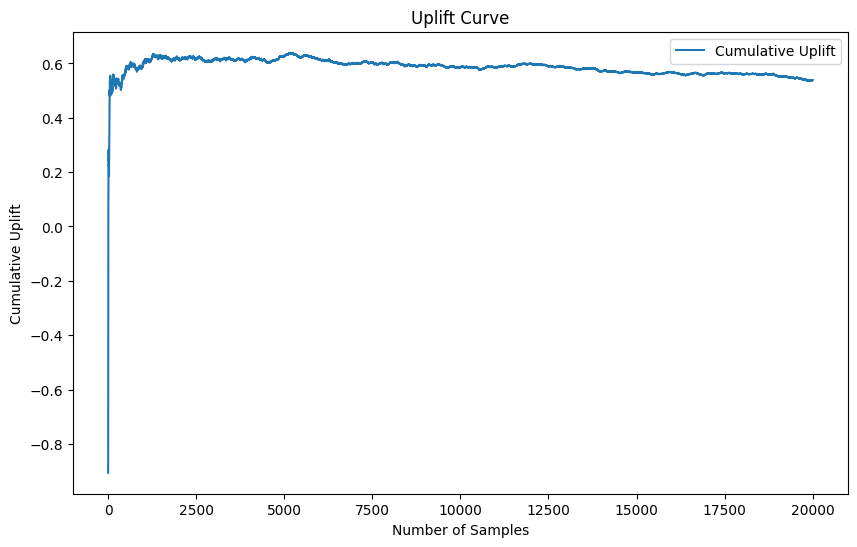

AUUC: 11737.982636681027


In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate the dataset as previously described
n = 100_000
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'time': time,
    'Y': Y
})

# Prepare the data for training
X = df_large[['time', 'X1', 'X2', 'T']].values
y = df_large['Y'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train[:, 1:3] = scaler.fit_transform(X_train[:, 1:3])
X_test[:, 1:3] = scaler.transform(X_test[:, 1:3])

# Define Transformer block
def transformer_block(inputs, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

# Define the neural network model
input0 = Input(shape=(1,), name='time')
input1 = Input(shape=(1,), name='treatment')
input2 = Input(shape=(2,), name='features')

# Concatenate inputs for the transformer block
concat_inputs = Concatenate()([input0, input1, input2])
concat_inputs = tf.expand_dims(concat_inputs, axis=1)

# Apply transformer block
transformer_output = transformer_block(concat_inputs, num_heads=2, ff_dim=32)
transformer_output = tf.squeeze(transformer_output, axis=1)

# Output layer
output = Dense(1)(transformer_output)

# Create the model
model = Model(inputs=[input0, input1, input2], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    [X_train[:, 0], X_train[:, 3], X_train[:, 1:3]], 
    y_train, 
    epochs=10, 
    batch_size=100, 
    validation_split=0.2, 
    verbose=1
)

# Evaluate the model
loss = model.evaluate([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
y_pred = model.predict([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]])
pred_mean = y_pred[:, 0]

# Calculate the uplift score
uplift_score = pred_mean - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score)[::-1]
y_test_sorted = y_test[sorted_indices]
T_test_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift = np.cumsum((T_test_sorted - (1 - T_test_sorted)) * y_test_sorted)
cumulative_uplift /= np.arange(1, len(cumulative_uplift) + 1)

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_uplift, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend()
plt.show()

# Calculate AUUC
auuc = np.trapz(cumulative_uplift)
print(f'AUUC: {auuc}')


Number of NaNs in the dataset: 0
Epoch 1/10


2024-06-01 16:47:08.987865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/64 [============================>.] - ETA: 0s - loss: nan

2024-06-01 16:47:11.403018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 3s 22ms/step - loss: nan - val_loss: nan
Epoch 2/10
64/64 [==============================] - 1s 12ms/step - loss: nan - val_loss: nan
Epoch 3/10
64/64 [==============================] - 1s 11ms/step - loss: nan - val_loss: nan
Epoch 4/10
64/64 [==============================] - 1s 11ms/step - loss: nan - val_loss: nan
Epoch 5/10
64/64 [==============================] - 1s 12ms/step - loss: nan - val_loss: nan
Epoch 6/10
64/64 [==============================] - 1s 11ms/step - loss: nan - val_loss: nan
Epoch 7/10
64/64 [==============================] - 1s 11ms/step - loss: nan - val_loss: nan
Epoch 8/10
64/64 [==============================] - 1s 12ms/step - loss: nan - val_loss: nan
Epoch 9/10
64/64 [==============================] - 1s 13ms/step - loss: nan - val_loss: nan
Epoch 10/10
64/64 [==============================] - 1s 12ms/step - loss: nan - val_loss: nan


2024-06-01 16:47:18.600601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: nan


2024-06-01 16:47:19.650742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 10ms/step


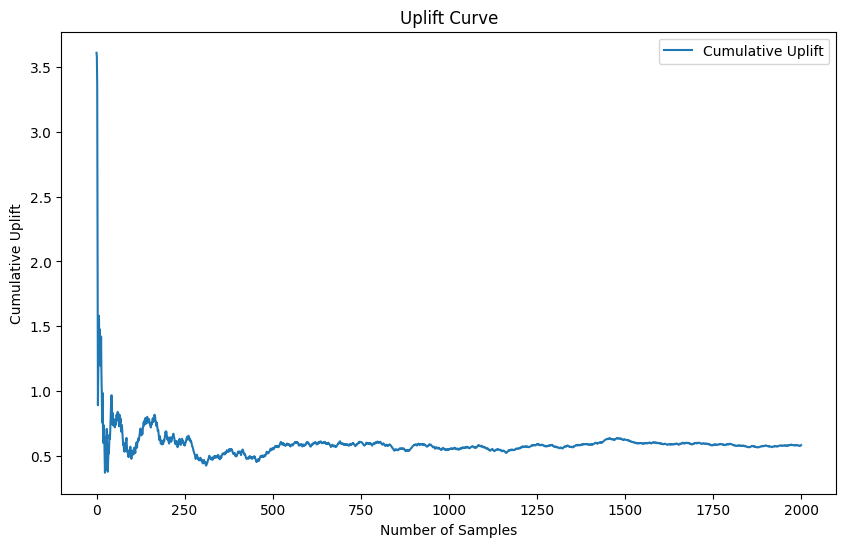

AUUC: 1182.5875081065524


In [63]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention, Lambda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate the dataset as previously described
n = 10000
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'time': time,
    'Y': Y
})

# Check for NaNs in the data
print("Number of NaNs in the dataset:", df_large.isnull().sum().sum())

# Prepare the data for training
X = df_large[['time', 'X1', 'X2', 'T']].values
y = df_large['Y'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train[:, 1:3] = scaler.fit_transform(X_train[:, 1:3])
X_test[:, 1:3] = scaler.transform(X_test[:, 1:3])

# Define Transformer block
def transformer_block(inputs, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

# Define the encoder
input0 = Input(shape=(1,), name='time')
input1 = Input(shape=(1,), name='treatment')
input2 = Input(shape=(2,), name='features')

# Concatenate inputs for the transformer block
concat_inputs = Concatenate()([input0, input1, input2])
concat_inputs = tf.expand_dims(concat_inputs, axis=1)

# Apply transformer block
transformer_output = transformer_block(concat_inputs, num_heads=2, ff_dim=32)
context = tf.squeeze(transformer_output, axis=1)

# Define the decoder
time_exp = Lambda(lambda x: tf.exp(x))(input0)
treatment_exp = Lambda(lambda x: tf.exp(x))(input1)

# Concatenate context with the exponential of time and treatment
decoder_input = Concatenate()([context, time_exp, treatment_exp])

# Output layers for mean and log variance
mean = Dense(1)(decoder_input)
log_variance = Dense(1)(decoder_input)

# Concatenate mean and variance to create a distribution
output = Concatenate()([mean, log_variance])

# Create the model
model = Model(inputs=[input0, input1, input2], outputs=output)

# Define the negative log-likelihood loss function
def nll(y_true, y_pred):
    mean = y_pred[:, 0]
    log_variance = y_pred[:, 1]
    variance = tf.exp(log_variance)
    return 0.5 * tf.reduce_mean(tf.math.log(2 * np.pi * variance) + tf.square(y_true - mean) / variance)

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=nll)

# Train the model with gradient clipping
history = model.fit(
    [X_train[:, 0], X_train[:, 3], X_train[:, 1:3]], 
    y_train, 
    epochs=10, 
    batch_size=100, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the model
loss = model.evaluate([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
y_pred = model.predict([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]])
pred_mean = y_pred[:, 0]

# Calculate the uplift score
uplift_score = pred_mean - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score)[::-1]
y_test_sorted = y_test[sorted_indices]
T_test_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift = np.cumsum((T_test_sorted - (1 - T_test_sorted)) * y_test_sorted)
cumulative_uplift /= np.arange(1, len(cumulative_uplift) + 1)

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_uplift, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend()
plt.show()

# Calculate AUUC
auuc = np.trapz(cumulative_uplift)
print(f'AUUC: {auuc}')


## All in one

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention, Lambda, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import spektral
from spektral.layers import GCNConv

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate the dataset as previously described
n = 10000
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'time': time,
    'Y': Y
})

# Check for NaNs in the data
print("Number of NaNs in the dataset:", df_large.isnull().sum().sum())

# Prepare the data for training
X = df_large[['time', 'X1', 'X2', 'T']].values
y = df_large['Y'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train[:, 1:3] = scaler.fit_transform(X_train[:, 1:3])
X_test[:, 1:3] = scaler.transform(X_test[:, 1:3])

# Transformer Model
def transformer_model():
    input0 = Input(shape=(1,), name='time')
    input1 = Input(shape=(1,), name='treatment')
    input2 = Input(shape=(2,), name='features')

    concat_inputs = Concatenate()([input0, input1, input2])
    concat_inputs = tf.expand_dims(concat_inputs, axis=1)

    def transformer_block(inputs, num_heads, ff_dim, dropout=0.1):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
        attn_output = Dropout(dropout)(attn_output)
        out1 = Add()([inputs, attn_output])
        out1 = LayerNormalization(epsilon=1e-6)(out1)

        ff_output = Dense(ff_dim, activation='relu')(out1)
        ff_output = Dense(inputs.shape[-1])(ff_output)
        ff_output = Dropout(dropout)(ff_output)
        return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

    transformer_output = transformer_block(concat_inputs, num_heads=2, ff_dim=32)
    context = tf.squeeze(transformer_output, axis=1)

    time_exp = Lambda(lambda x: tf.exp(x))(input0)
    treatment_exp = Lambda(lambda x: tf.exp(x))(input1)

    decoder_input = Concatenate()([context, time_exp, treatment_exp])

    mean = Dense(1)(decoder_input)
    log_variance = Dense(1)(decoder_input)

    output = Concatenate()([mean, log_variance])

    model = Model(inputs=[input0, input1, input2], outputs=output)

    return model

# GCN Model
def gcn_model():
    graph_input = Input(shape=(X_train.shape[1],))
    adj_input = Input(shape=(X_train.shape[1],))

    gcn1 = GCNConv(32, activation='relu')([graph_input, adj_input])
    gcn2 = GCNConv(32, activation='relu')([gcn1, adj_input])
    gcn3 = GCNConv(1)([gcn2, adj_input])

    output = Flatten()(gcn3)

    model = Model(inputs=[graph_input, adj_input], outputs=output)

    return model

# NN Model
def nn_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    return model

# Define the negative log-likelihood loss function
def nll(y_true, y_pred):
    mean = y_pred[:, 0]
    log_variance = y_pred[:, 1]
    variance = tf.exp(log_variance)
    return 0.5 * tf.reduce_mean(tf.math.log(2 * np.pi * variance) + tf.square(y_true - mean) / variance)

# Compile the models
transformer = transformer_model()
transformer.compile(optimizer=Adam(learning_rate=0.001), loss=nll)

# For GCN, we need to create an adjacency matrix. For simplicity, we will use an identity matrix.
adj_matrix = np.identity(X_train.shape[1])

gcn = gcn_model()
gcn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

nn = nn_model()
nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the models
transformer_history = transformer.fit(
    [X_train[:, 0], X_train[:, 3], X_train[:, 1:3]],
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

gcn_history = gcn.fit(
    [X_train, adj_matrix],
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

nn_history = nn.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the models
transformer_loss = transformer.evaluate([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]], y_test, verbose=0)
print(f'Transformer Test loss: {transformer_loss}')

gcn_loss = gcn.evaluate([X_test, adj_matrix], y_test, verbose=0)
print(f'GCN Test loss: {gcn_loss}')

nn_loss = nn.evaluate(X_test, y_test, verbose=0)
print(f'NN Test loss: {nn_loss}')

# Make predictions
y_pred_transformer = transformer.predict([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]])[:, 0]
y_pred_gcn = gcn.predict([X_test, adj_matrix]).flatten()
y_pred_nn = nn.predict(X_test).flatten()

# Plot true vs predicted values for control and treatment groups
control_indices = X_test[:, 3] == 0
treatment_indices = X_test[:, 3] == 1

plt.figure(figsize=(12, 6))

# Transformer
plt.subplot(1, 3, 1)
plt.scatter(y_test[control_indices], y_pred_transformer[control_indices], alpha=0.5, label='Control', color='blue')
plt.scatter(y_test[treatment_indices], y_pred_transformer[treatment_indices], alpha=0.5, label='Treatment', color='orange')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Transformer')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal')
plt.legend()

# GCN
plt.subplot(1, 3, 2)
plt.scatter(y_test[control_indices], y_pred_gcn[control_indices], alpha=0.5, label='Control', color='blue')
plt.scatter(y_test[treatment_indices], y_pred_gcn[treatment_indices], alpha=0.5, label='Treatment', color='orange')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('GCN')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', label='Ideal')
plt.legend()


ModuleNotFoundError: No module named 'tensorflow_probability'